In [1]:
import numpy as np 
import pandas as pd 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from utils.extractor import model_accuracy
import seaborn as sns
import re
import matplotlib.pyplot as plt
import missingno as ms
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [2]:
training_data = pd.read_csv('train.csv') 
testing_data = pd.read_csv('test.csv') 

In [3]:
training_data.shape, testing_data.shape 

((31962, 3), (17197, 2))

In [4]:
training_data.head(10) 

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


In [5]:
training_data.info() 
training_data['label'].value_counts() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
id       31962 non-null int64
label    31962 non-null int64
tweet    31962 non-null object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


0    29720
1     2242
Name: label, dtype: int64

c:\users\sridhar\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



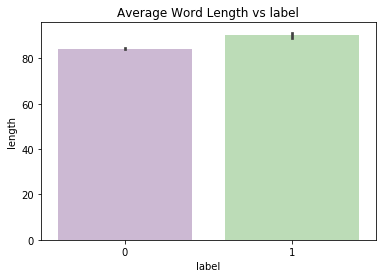

In [6]:
training_data['length'] = training_data['tweet'].apply(len)
fig1 = sns.barplot('label','length',data = training_data,palette='PRGn')
plt.title('Average Word Length vs label')
plot = fig1.get_figure()
plot.savefig('Barplot.png')

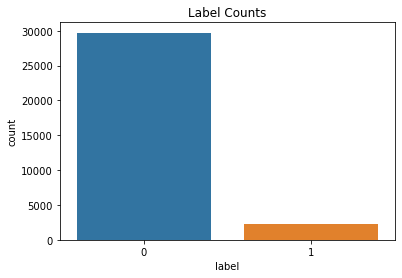

In [7]:
fig2 = sns.countplot(x= 'label',data = training_data)
plt.title('Label Counts')
plot = fig2.get_figure()
plot.savefig('Count Plot.png')

In [8]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
training_data['length'].iplot(
    kind='hist',
    bins=100,
    xTitle='word count',
    linecolor='black',
    yTitle='count',
    title='Review Text Word Count Distribution')

In [9]:
def vectorization(table):
    
    vector = CountVectorizer()
    
    frequency_matrix = vector.fit_transform(table.tweet)
    
    sum_frequencies = np.sum(frequency_matrix, axis=0)
   
    frequency = np.squeeze(np.asarray(sum_frequencies))
    
    frequency_df = pd.DataFrame([frequency], columns=vector.get_feature_names()).transpose()
    return frequency_df

In [10]:
def graph(word_frequency, sent):
    labels = word_frequency[0][1:51].index
    title = "Word Frequency for %s" %sent
    #Plot the figures
    plt.figure(figsize=(10,5))
    plt.bar(np.arange(50), word_frequency[0][1:51], width = 0.8, color = sns.color_palette("bwr"), alpha=0.5, 
            edgecolor = "black", capsize=8, linewidth=1);
    plt.xticks(np.arange(50), labels, rotation=90, size=14);
    plt.xlabel("50 more frequent words", size=14);
    plt.ylabel("Frequency", size=14);
    #plt.title('Word Frequency for %s', size=18) %sent;
    plt.title(title, size=18)
    plt.grid(False);
    plt.gca().spines["top"].set_visible(False);
    plt.gca().spines["right"].set_visible(False);
    plt.show()

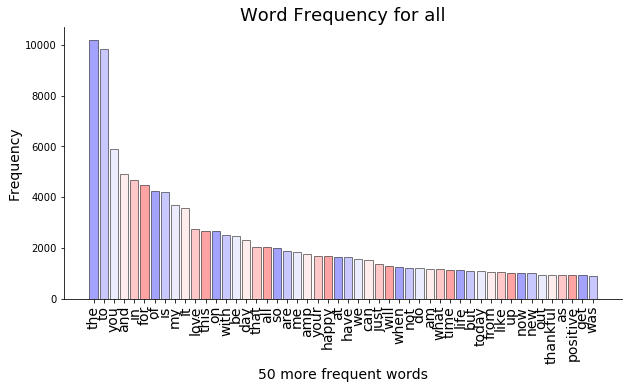

In [11]:
word_frequency = vectorization(training_data).sort_values(0, ascending = False)


   
graph(word_frequency, 'all')


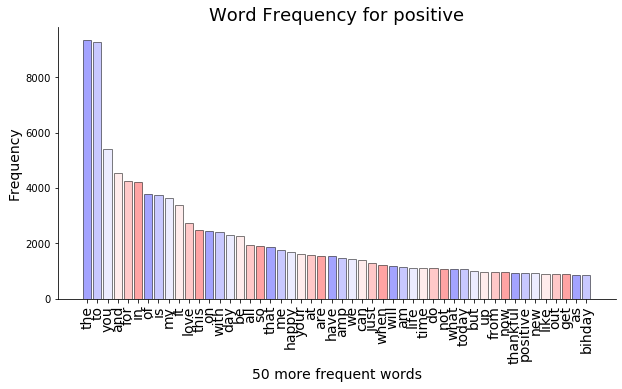

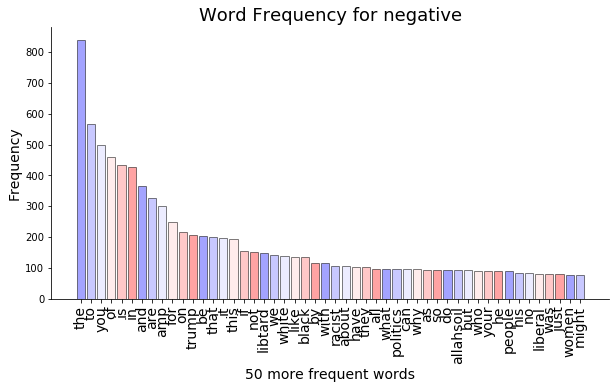

In [12]:
word_frequency_pos = vectorization(training_data[training_data['label'] == 0]).sort_values(0, ascending = False)
word_frequency_neg = vectorization(training_data[training_data['label'] == 1]).sort_values(0, ascending = False)

graph(word_frequency_pos, 'positive')
graph(word_frequency_neg, 'negative')

In [13]:
def regression_graph(table):
    table = table[1:]
   
    sns.set_style("whitegrid")   
   
    plt.figure(figsize=(6,6))
    

    points = plt.scatter(table["Positive"], table["Negative"], c=table["Positive"], s=75, cmap="bwr")
   
    plt.colorbar(points)
   
    sns.regplot(x="Positive", y="Negative",fit_reg=False, scatter=False, color=".1", data=table)
    plt.xlabel("Frequency for Positive Tweets", size=14)
    plt.ylabel("Frequency for Negative Tweets", size=14)
    plt.title("Word frequency in Positive vs. Negative Tweets", size=14)
    plt.grid(False)
    sns.despine()

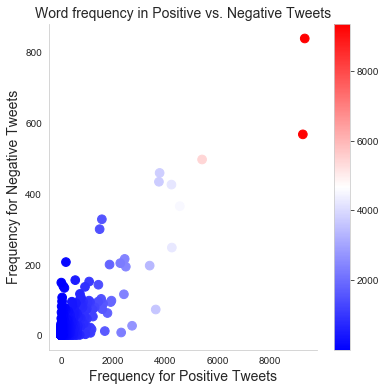

In [14]:
table_regression = pd.concat([word_frequency_pos, word_frequency_neg], axis=1, sort=False)
table_regression.columns = ["Positive", "Negative"]
regression_graph(table_regression)

In [15]:
testing_data.head(10)
def drop_features(features,data):
    data.drop(features,inplace=True,axis=1)

In [16]:
def process_tweet(tweet):
    return " ".join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])", " ",tweet.lower()).split())

In [17]:
training_data['processed_tweets'] = training_data['tweet'].apply(process_tweet)

In [18]:
training_data.head(15)

,id,label,tweet,length,processed_tweets
0,1,0,@user when a father is dysfunctional and is s...,102,when a father is dysfunctional and is so selfi...
1,2,0,@user @user thanks for #lyft credit i can't us...,122,thanks for lyft credit i can t use cause they ...
2,3,0,bihday your majesty,21,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,86,model i love u take with u all the time in ur
4,5,0,factsguide: society now #motivation,39,factsguide society now motivation
5,6,0,[2/2] huge fan fare and big talking before the...,116,2 2 huge fan fare and big talking before they ...
6,7,0,@user camping tomorrow @user @user @user @use...,74,camping tomorrow danny
7,8,0,the next school year is the year for exams.ð...,143,the next school year is the year for exams can...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...,87,we won love the land allin cavs champions clev...
9,10,0,@user @user welcome here ! i'm it's so #gr...,50,welcome here i m it s so gr8


In [19]:
drop_features(['id','tweet'],training_data)
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
label               31962 non-null int64
length              31962 non-null int64
processed_tweets    31962 non-null object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [20]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(training_data["processed_tweets"], training_data["label"], test_size = 0.2, random_state = 42)
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
count_vect = CountVectorizer(stop_words='english')
transformer = TfidfTransformer(norm='l2',sublinear_tf=True)

In [21]:
x_train_counts = count_vect.fit_transform(x_train)
x_train_tfidf = transformer.fit_transform(x_train_counts)

In [22]:
print(x_train_counts.shape)
print(x_train_tfidf.shape)
x_train_counts
x_test_counts = count_vect.transform(x_test)
x_test_tfidf = transformer.transform(x_test_counts)
test_size=4
random_state=0.5
acc=[]

(25569, 33735)
(25569, 33735)


In [23]:
from keras.models import Sequential
from keras.layers import Dense
model_rnn= Sequential()
model_rnn.add(Dense(11,activation='relu'))
model_rnn.add(Dense(1,activation='sigmoid'))
model_rnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
acc.append(model_accuracy(test_size,random_state)*100)

Using TensorFlow backend.
c:\users\sridhar\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

c:\users\sridhar\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

c:\users\sridhar\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

c:\users\sridhar\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning:

In [24]:
x_train_counts = count_vect.fit_transform(x_train)
x_train_tfidf = transformer.fit_transform(x_train_counts)

In [25]:
x_train_counts
x_test_counts = count_vect.transform(x_test)
x_test_tfidf = transformer.transform(x_test_counts)

In [26]:
no_feature=10
randomness=5

In [27]:
from keras.models import Sequential
from keras.layers import Dense
test_size=7
random_state=0.5
model_rnn= Sequential()
model_rnn.add(Dense(11,activation='relu'))
model_rnn.add(Dense(1,activation='sigmoid'))
model_rnn.add(Dense(11,activation='relu'))
model_rnn.add(Dense(1,activation='sigmoid'))
model_rnn.add(Dense(11,activation='relu'))
model_rnn.add(Dense(1,activation='sigmoid'))
model_rnn.add(Dense(11,activation='relu'))
model_rnn.add(Dense(1,activation='sigmoid'))

model_rnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
acc.append(model_accuracy(test_size,random_state)*100)

(70, 100)

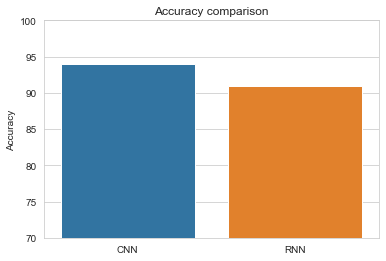

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
x=['CNN','RNN']
y=acc

ax=sns.barplot(x,y)
ax.set_title('Accuracy comparison')
ax.set_ylabel('Accuracy')
#ax.yaxis.set_major_locator(ticker.LinearLocator())
low = min(y)
high = max(y)
ax.set_ylim(70,100)
